<div class="alert alert-block alert-info">
Section of the book chapter: <b>4. Regression on Feature Level</b>
</div>

# 2. Feature Level


**Table of Contents**

* [2.1 Dimensionality reduction](#2.1-Dimensionality-reduction)
* [2.2 Clustering](#2.2-Clustering)
* [2.3 Feature Engineering and Feature Selection](#2.3-Feature-Engineering-and-Feature-Selection)


**Learnings:**

- how to implement different approaches of dimensionality reduction in Python 3,
- how to visualize the results of dimensionality reduction,
- how to implement different approaches of clustering in Python 3,
- how to implement exemplary feature generation of the NDVI and select features based on a feature importance metric.



### Packages

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# ignore warnings
import os
import warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["KMP_WARNINGS"] = "0"  # ignore umap warning
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import utils

### Read in Data

**Dataset:** Felix M. Riese and Sina Keller, "Hyperspectral benchmark dataset on soil moisture", Dataset, Zenodo, 2018. [DOI:10.5281/zenodo.1227836](http://doi.org/10.5281/zenodo.1227836) and [GitHub](https://github.com/felixriese/hyperspectral-soilmoisture-dataset)

**Introducing paper:** Felix M. Riese and Sina Keller, “Introducing a Framework of Self-Organizing Maps for Regression of Soil Moisture with Hyperspectral Data,” in IGARSS 2018 - 2018 IEEE International Geoscience and Remote Sensing Symposium, Valencia, Spain, 2018, pp. 6151-6154. [DOI:10.1109/IGARSS.2018.8517812](https://doi.org/10.1109/IGARSS.2018.8517812)

In [2]:
X, y = utils.get_xy()
print(X.shape, y.shape)

(679, 125) (679,)


### Plot Configurations

In [3]:
norm = mpl.colors.Normalize(vmin=np.min(y), vmax=np.max(y))
cmap = "cividis_r"

### Fix Random State

In [4]:
import tensorflow as tf

np.random.seed(42)
tf.random.set_seed(43)

***

## 2.1 Dimensionality reduction

Approaches:

- [2.1.1 Principal Component Analysis (PCA](#2.1.1-Principal-Component-Analysis,-PCA)
- ~~Maximum Noise Fraction (MNF)~~ **&rarr; no adequate package available!**
- [2.1.2 Autoencoder (AE)](#2.1.2-Autoencoder,-AE)
- [2.1.3 t-Distributed Stochastic Neighbor Embedding (t-SNE)](#2.1.3-t-Distributed-Stochastic-Neighbor-Embedding,-t-SNE)
- [2.1.4 Uniform Manifold Approximation and Projection (UMAP)](#2.1.4-Uniform-Manifold-Approximation-and-Projection,-UMAP)
- [2.1.5 Summary](#2.1.5-Summary)

### 2.1.1 Principal Component Analysis, PCA

Implementation: [sklearn.decomposition.PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

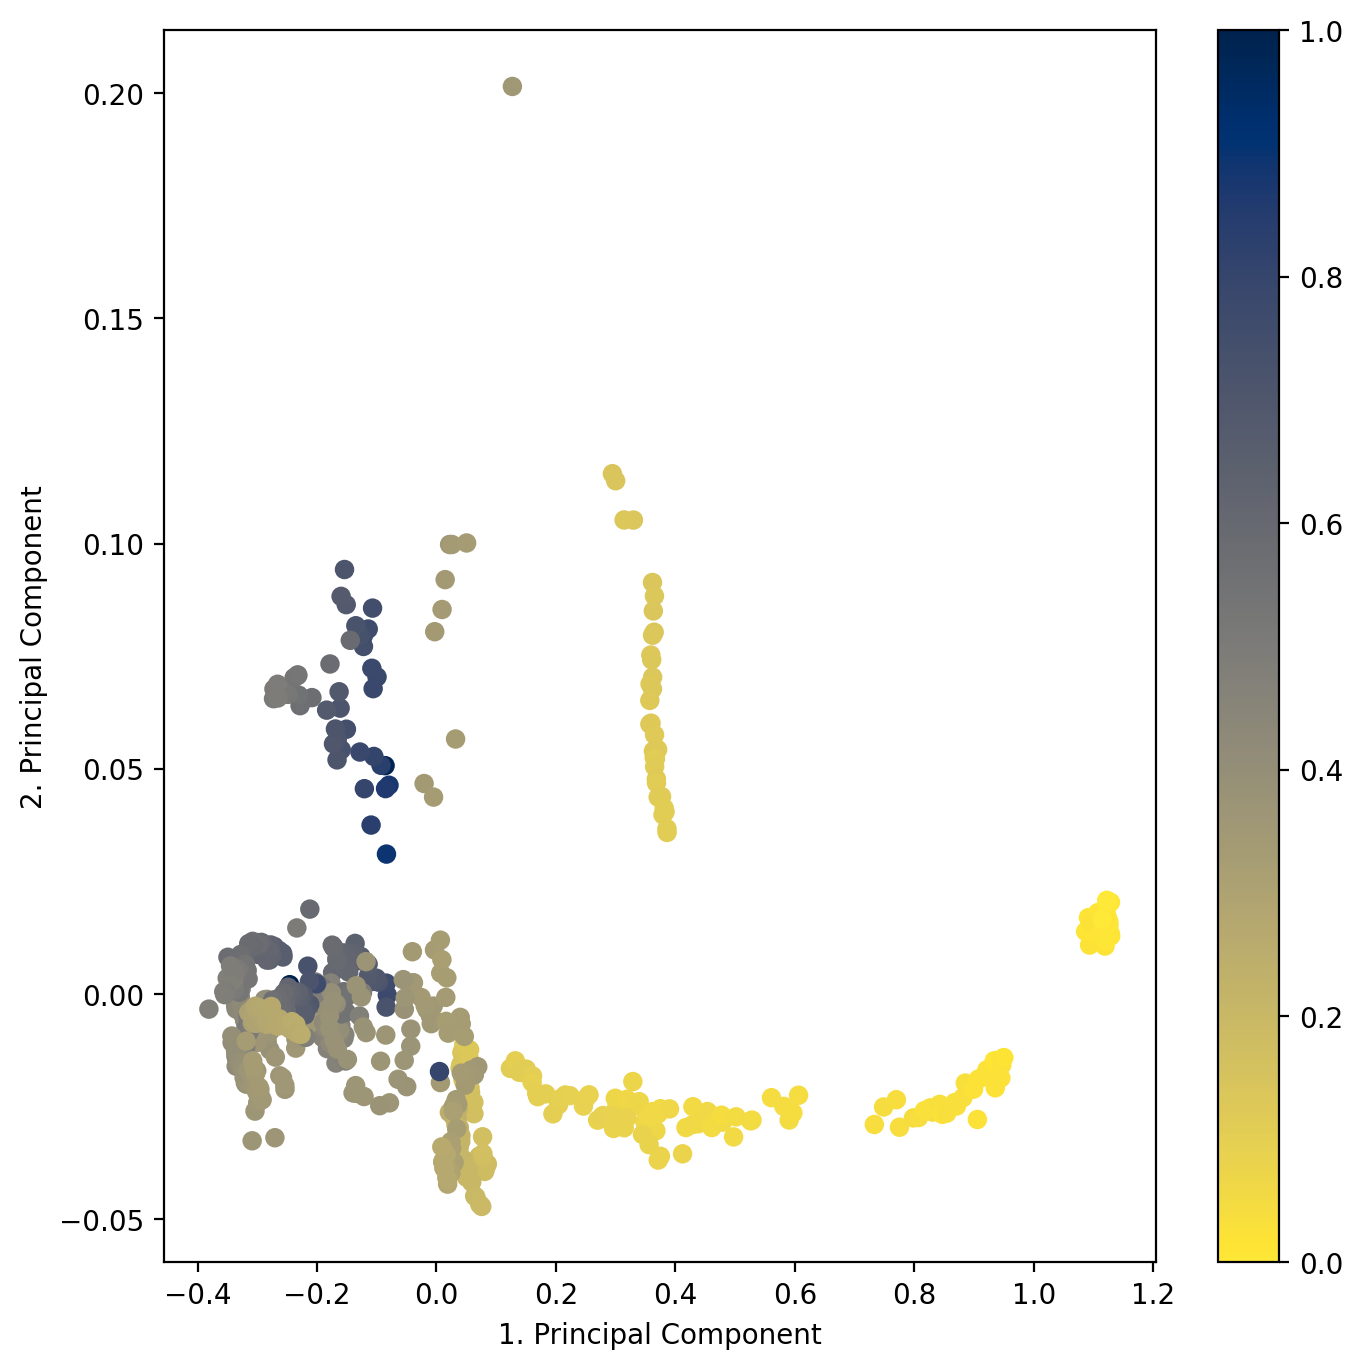

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)


plt.figure(figsize=(8,8))
plt.scatter(X_pca[:,0], X_pca[:,1], c=norm(y), cmap=cmap)
plt.xlabel("1. Principal Component")
plt.ylabel("2. Principal Component")
cbar = plt.colorbar(drawedges=False)

### 2.1.2 Autoencoder, AE

In [6]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow import keras
from sklearn.preprocessing import Normalizer

keras.backend.clear_session()

X_norm = Normalizer().fit_transform(X)

def get_autoencoder():

    input = Input(shape=(125,))

    encoded = Dense(3, activation="relu")(input)
    decoded = Dense(125, activation="linear")(encoded)

    return Model(input, decoded), Model(input, encoded)

autoencoder, encoder = get_autoencoder()
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.fit(X_norm, X_norm, epochs=20, batch_size=5, shuffle=True, verbose=0)

print("Fitted!")

Fitted!


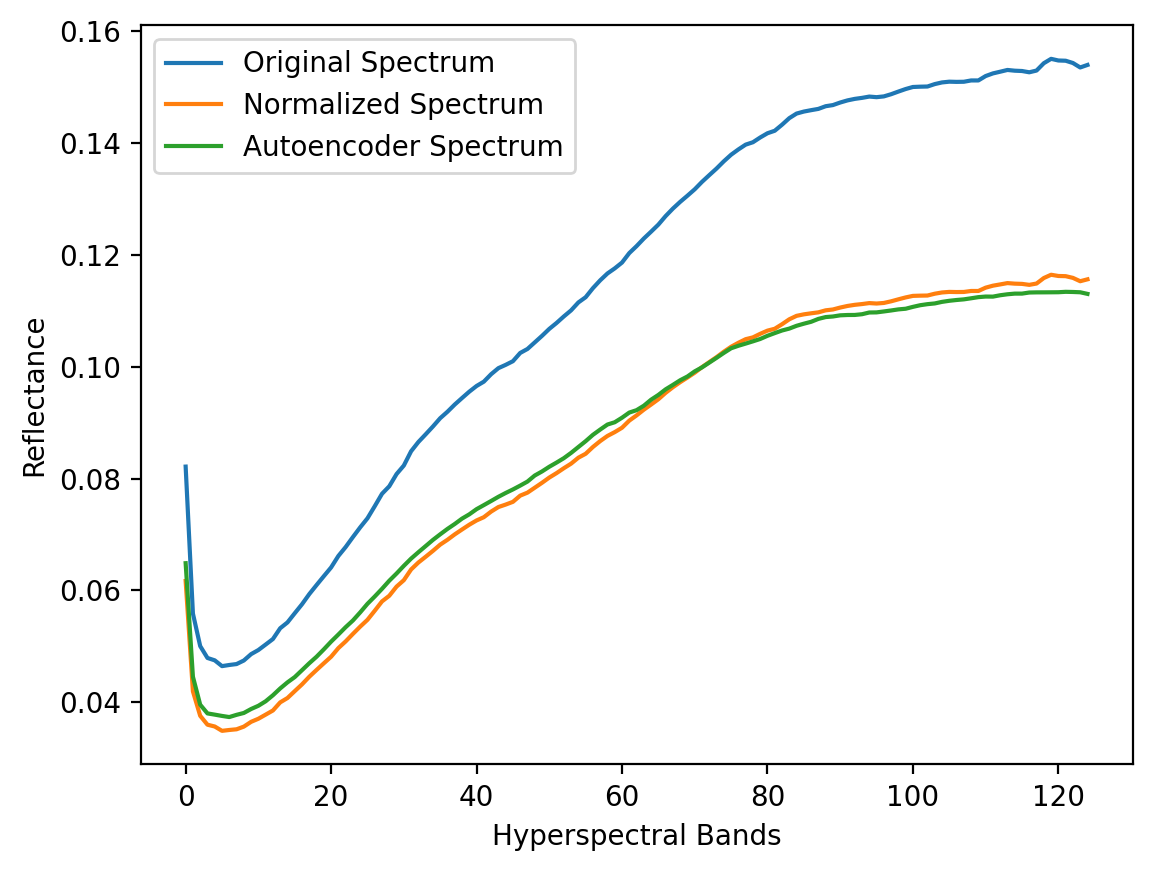

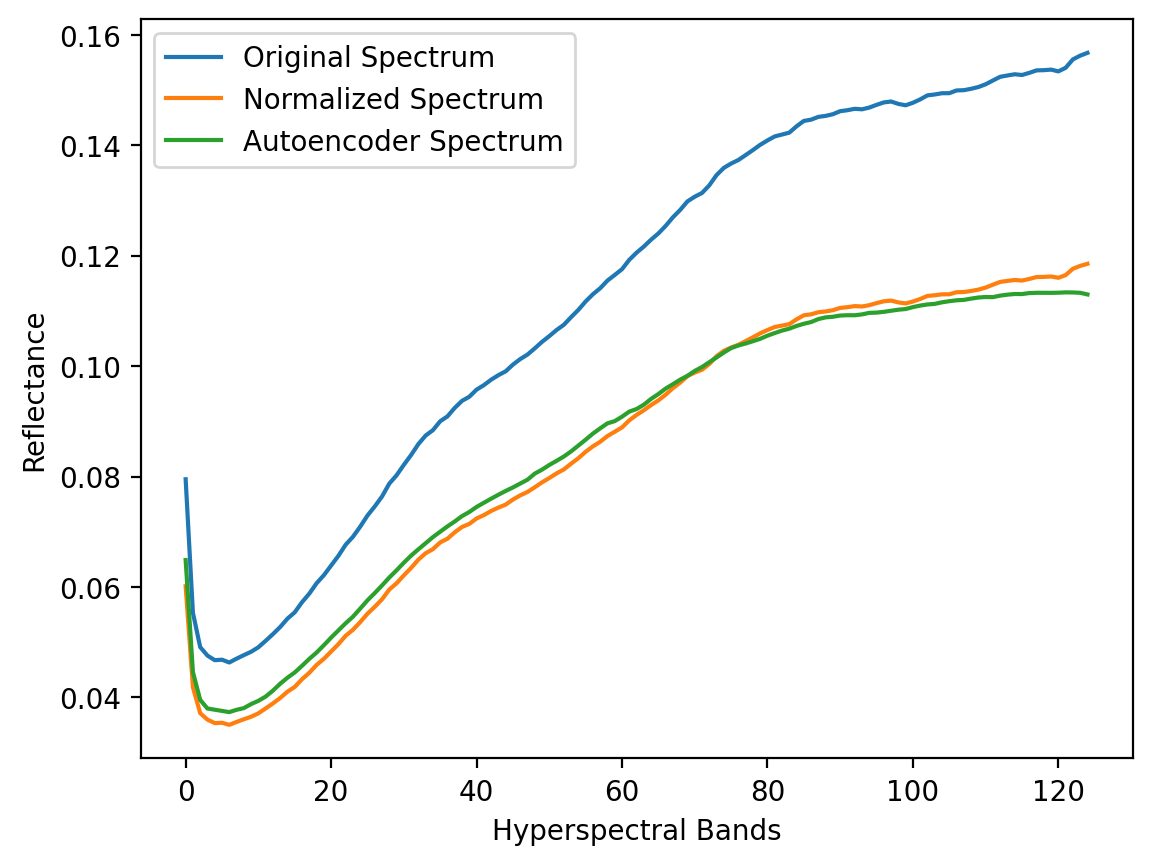

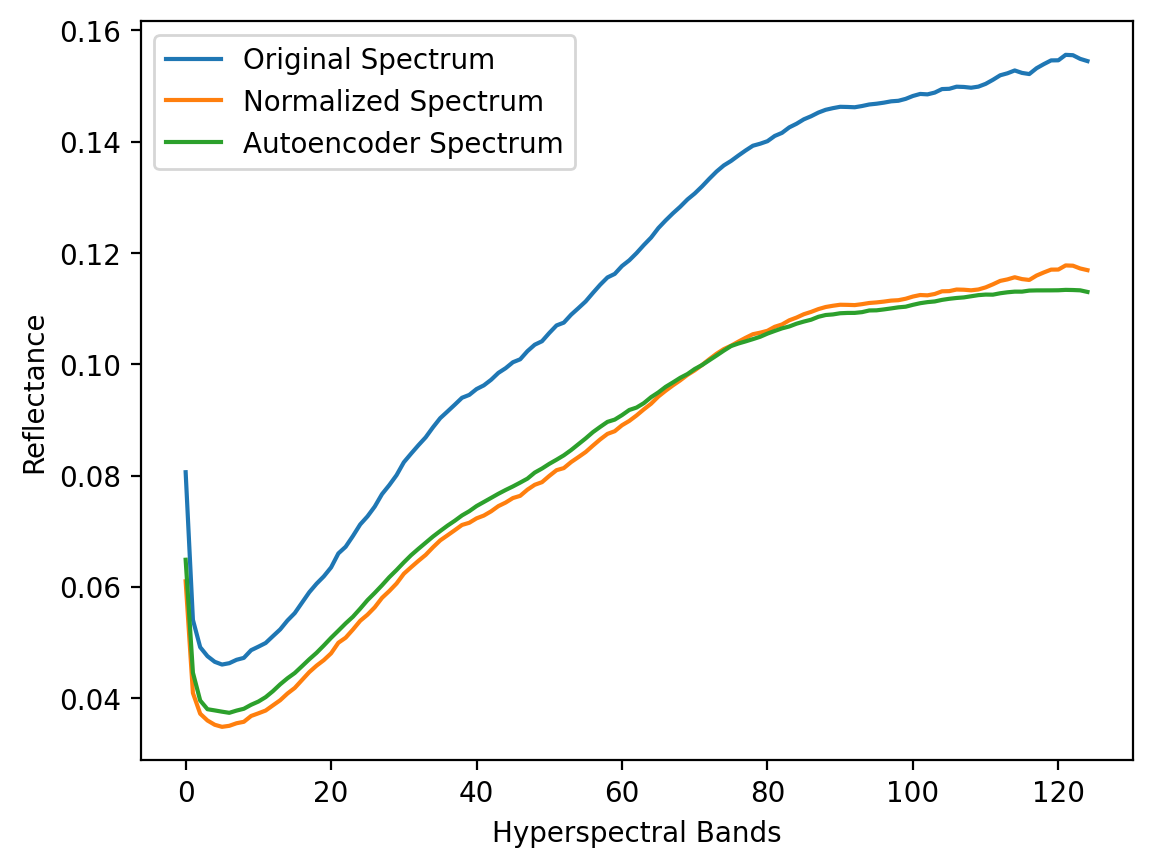

In [7]:
X_autoenc = autoencoder.predict(X_norm, verbose=None)
X_enc = encoder.predict(X_norm, verbose=None)

for i in range(3):
    plt.plot(X[i], label="Original Spectrum")
    plt.plot(X_norm[i], label="Normalized Spectrum")
    plt.plot(X_autoenc[i], label="Autoencoder Spectrum")
    plt.xlabel("Hyperspectral Bands")
    plt.ylabel("Reflectance")
    plt.legend()
    
    plt.show()

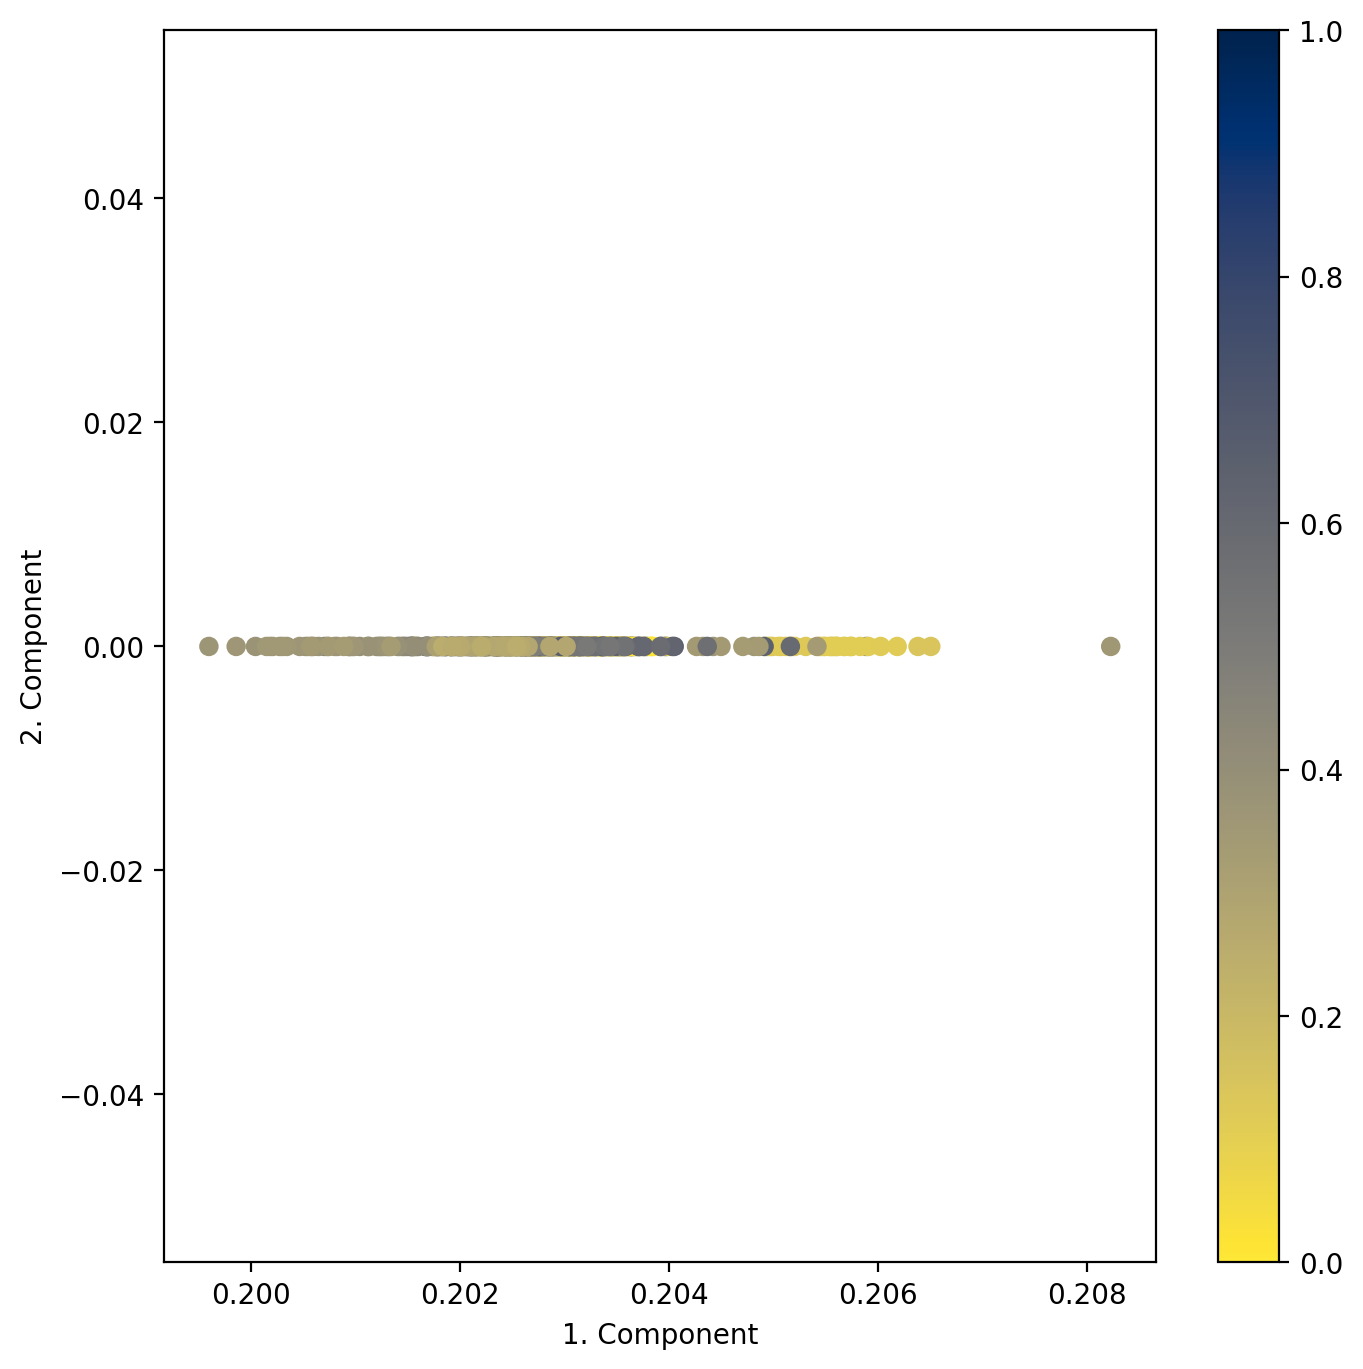

In [8]:
plt.figure(figsize=(8,8))
plt.scatter(X_enc[:,0], X_enc[:,1], c=norm(y), cmap=cmap)
plt.xlabel("1. Component")
plt.ylabel("2. Component")
plt.colorbar()
plt.show()

### 2.1.3 t-Distributed Stochastic Neighbor Embedding, t-SNE
Implementation: [sklearn.manifold.TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

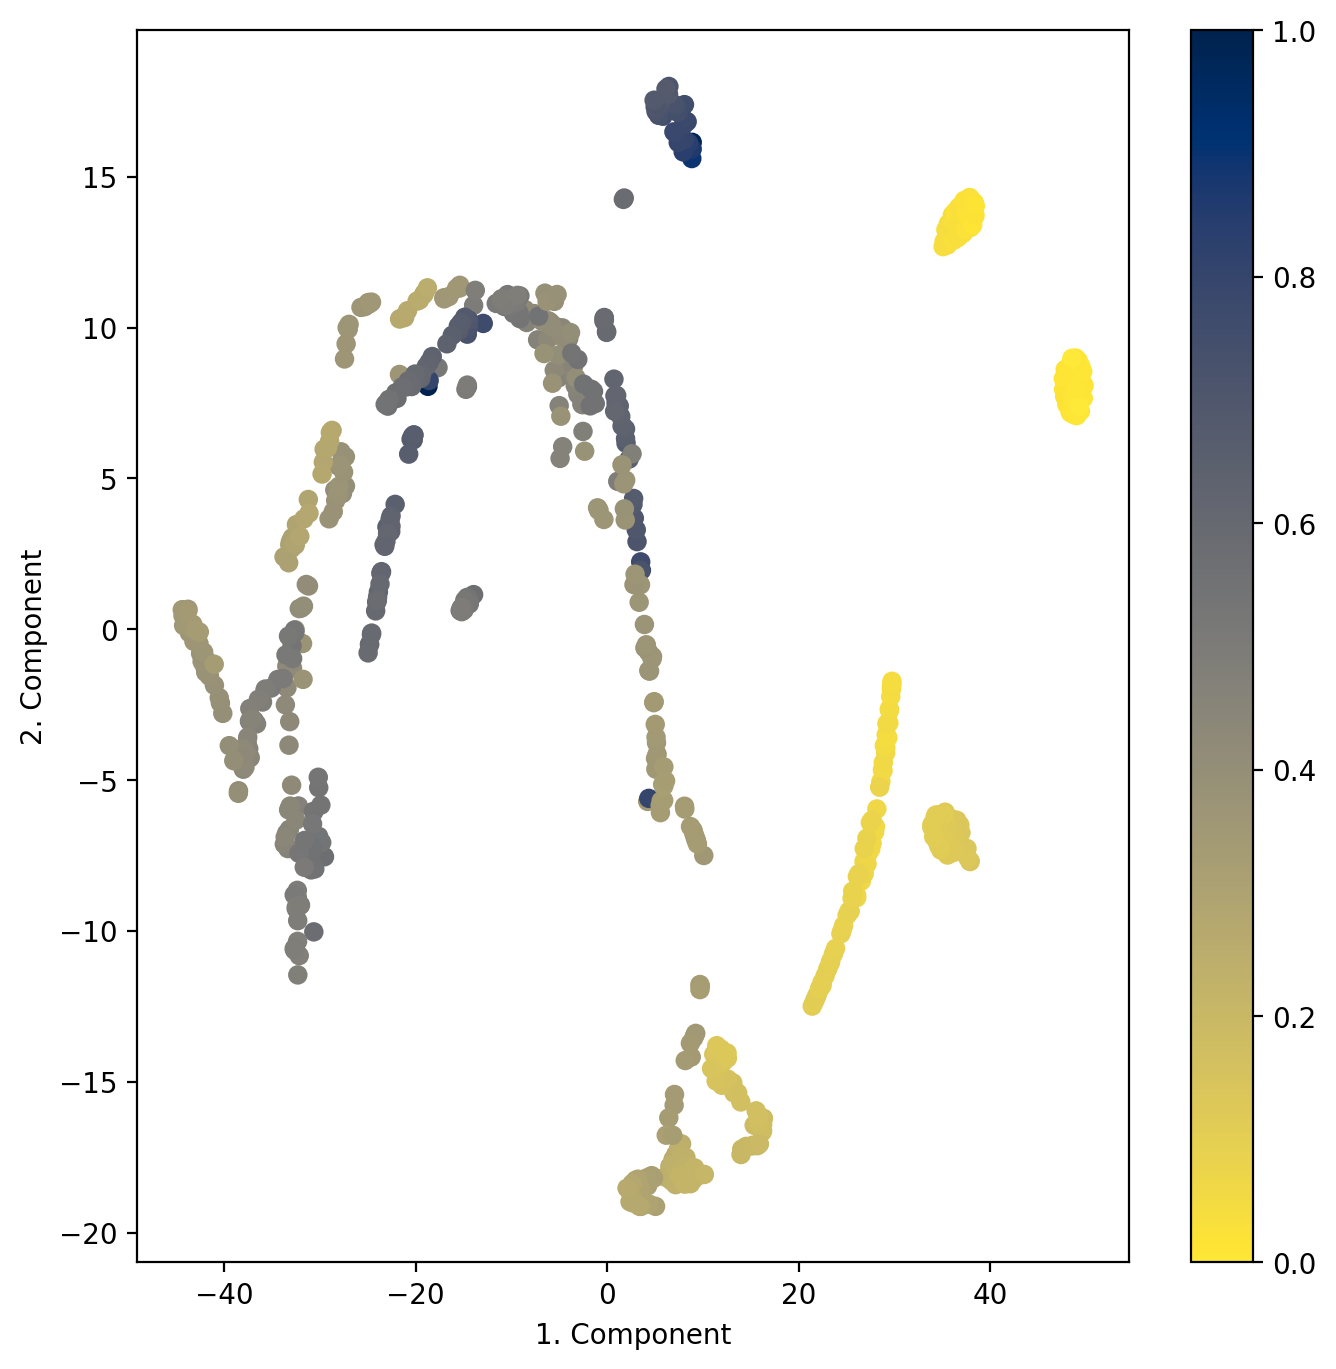

In [9]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(8,8))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=norm(y), cmap=cmap)
plt.xlabel("1. Component")
plt.ylabel("2. Component")
plt.colorbar()
plt.show()

### 2.1.4 Uniform Manifold Approximation and Projection, UMAP
Implementation: [GitHub](https://github.com/lmcinnes/umap) or PyPi with `pip install umap-learn`.

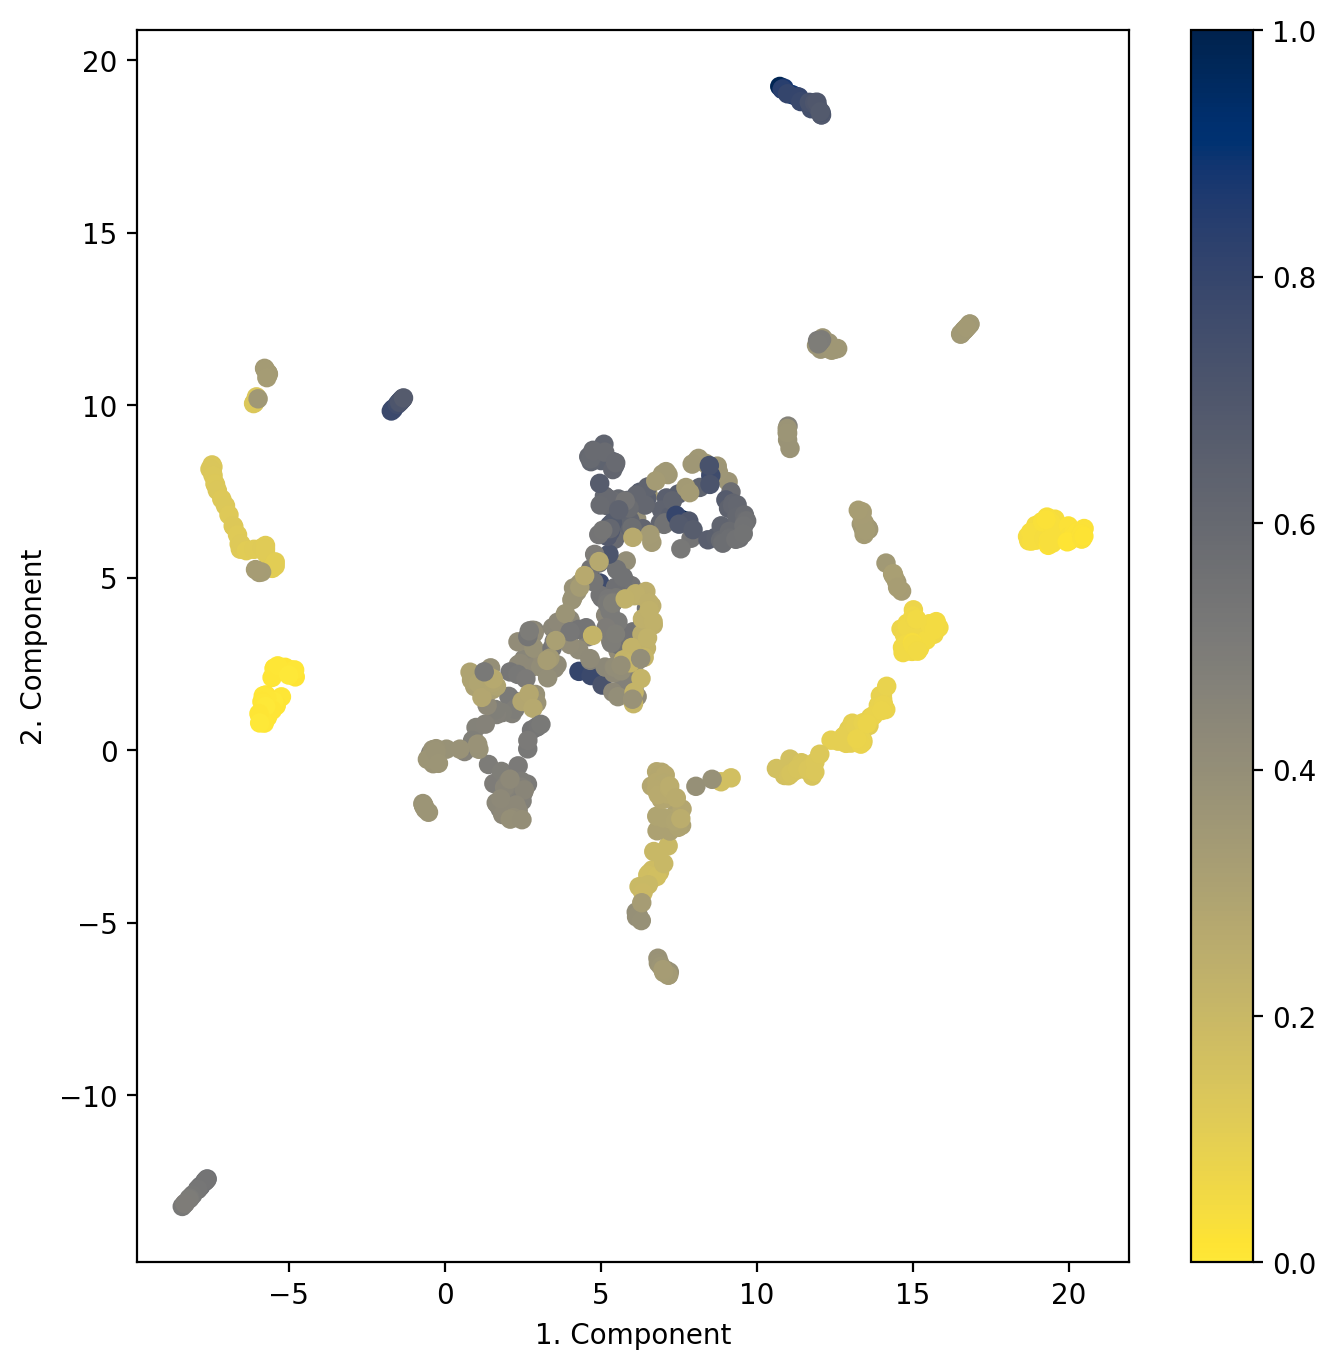

In [10]:
import umap.umap_ as umap

my_umap = umap.UMAP(n_neighbors=5, min_dist=0.3, metric='correlation')
embedding = my_umap.fit_transform(X)

plt.figure(figsize=(8,8))
plt.scatter(embedding[:,0], embedding[:,1], c=norm(y), cmap=cmap)
plt.xlabel("1. Component")
plt.ylabel("2. Component")
plt.colorbar()
plt.show()

### 2.1.5 Summary

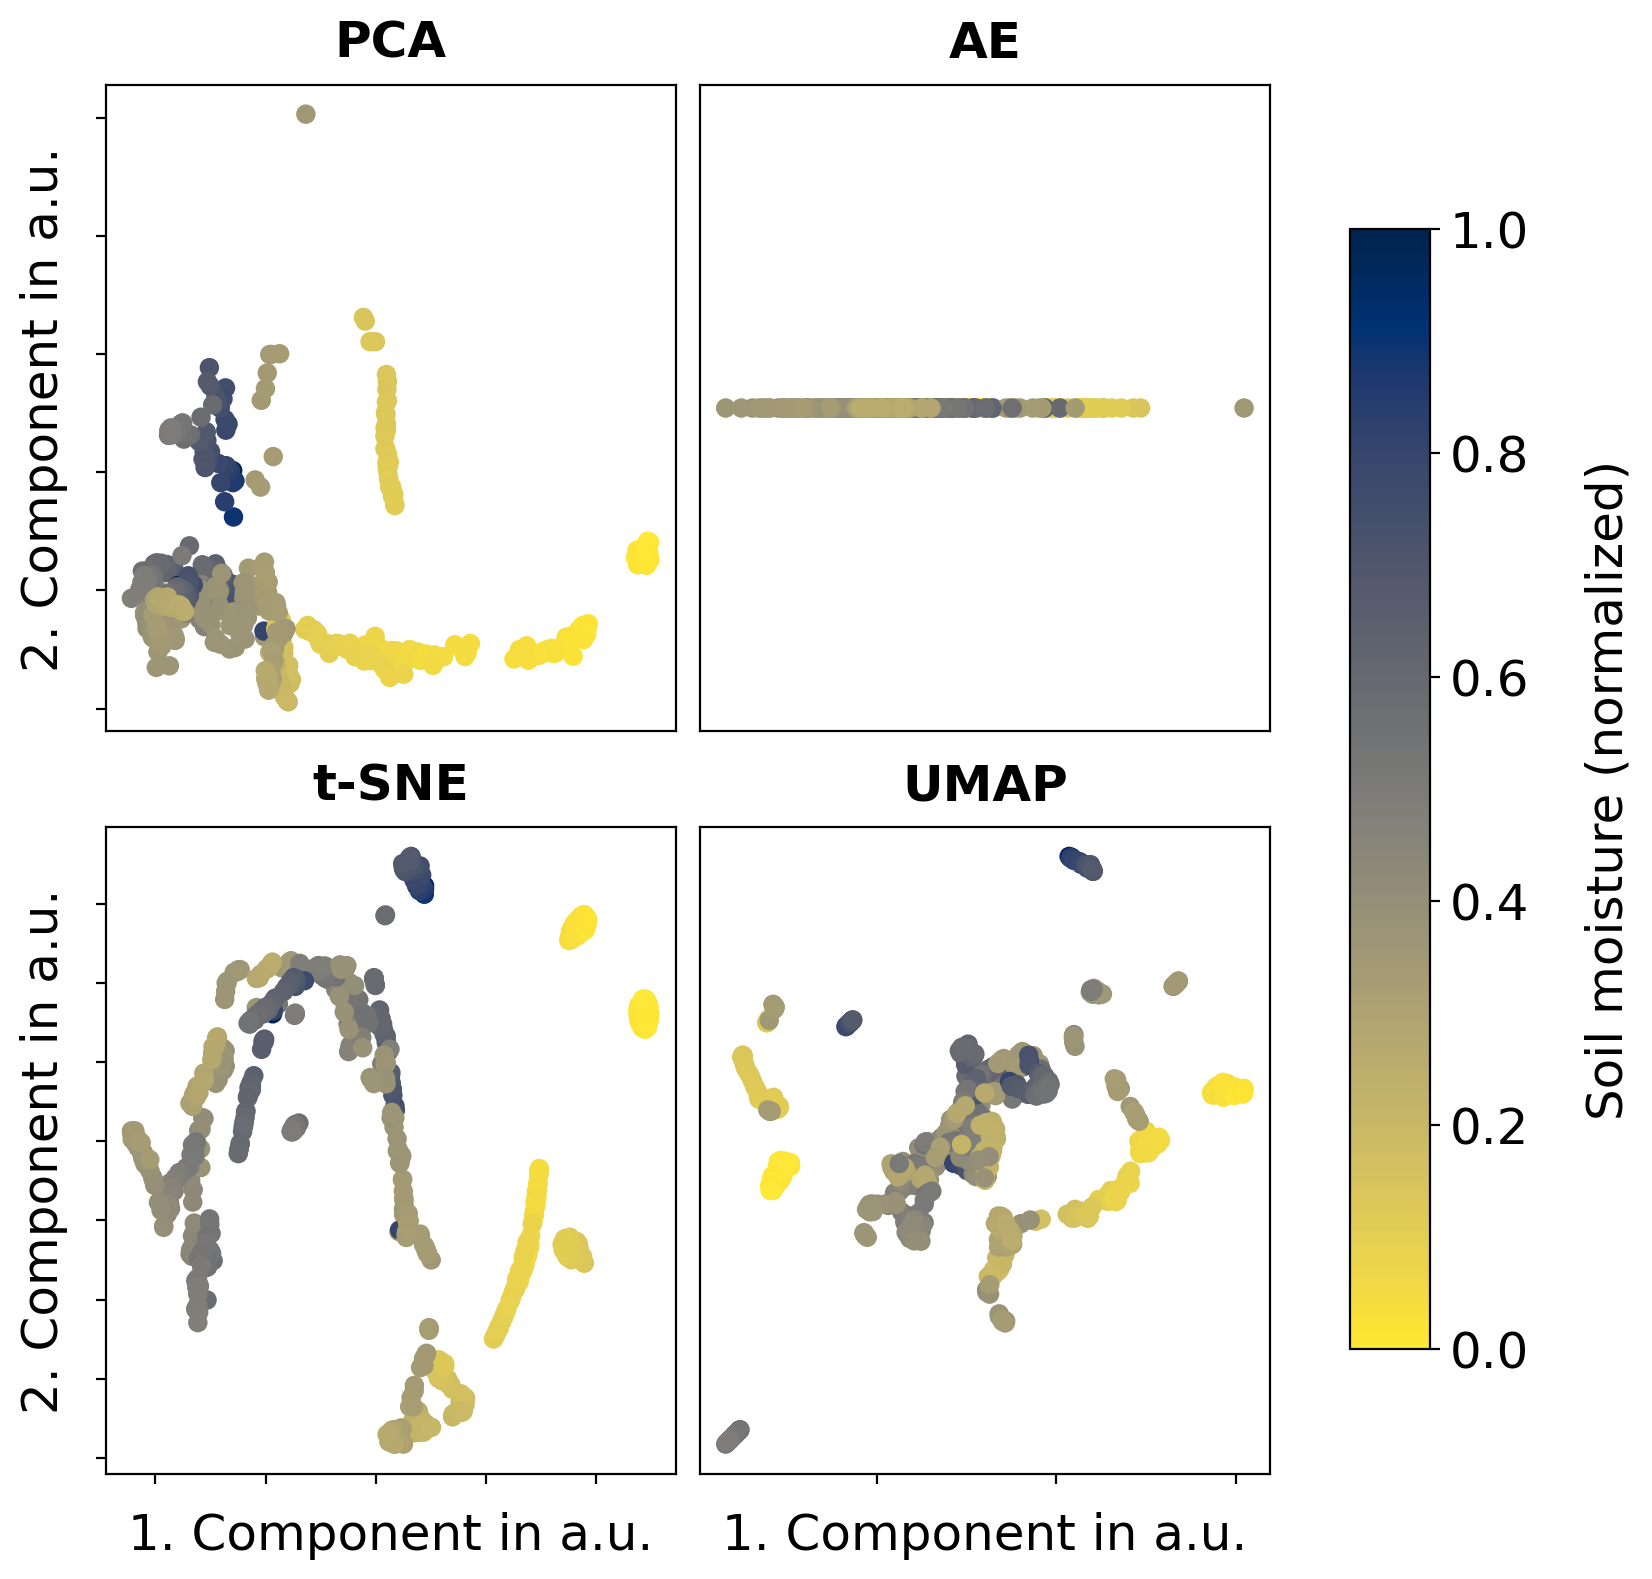

In [11]:
fontsize = 18
titleweight = "bold"
titlepad = 10
labelpad = 10

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 8))

# PCA
scat = ax1.scatter(X_pca[:,0], X_pca[:,1], c=norm(y), cmap=cmap)
ax1.set_title("PCA", fontsize=fontsize, fontweight=titleweight, pad=titlepad)

# Autoencoder
ax2.scatter(X_enc[:,0], X_enc[:,1], c=norm(y), cmap=cmap)
ax2.set_title("AE", fontsize=fontsize, fontweight=titleweight, pad=titlepad)

# t-SNE
ax3.scatter(X_tsne[:,0], X_tsne[:,1], c=norm(y), cmap=cmap)
ax3.set_title("t-SNE", fontsize=fontsize, fontweight=titleweight, pad=titlepad)

# UMAP
ax4.scatter(embedding[:,0], embedding[:,1], c=norm(y), cmap=cmap)
ax4.set_title("UMAP", fontsize=fontsize, fontweight=titleweight, pad=titlepad)


# Global settings
for i, ax in enumerate([ax1, ax2, ax3, ax4]):
    
    ax.set_xlabel("1. Component in a.u.", fontsize=fontsize, labelpad=labelpad)
    ax.set_ylabel("2. Component in a.u.", fontsize=fontsize, labelpad=labelpad)
    
    # ax.set_axis_off()
    for tick in ax.xaxis.get_major_ticks()[::]:
        tick.label.set_visible(False)
    # for tick in ax.xaxis.get_major_ticks():
    #     tick.label.set_fontsize(fontsize) 
    for tick in ax.yaxis.get_major_ticks()[::]:
        tick.label.set_visible(False)
    # for tick in ax.yaxis.get_major_ticks():
    #     tick.label.set_fontsize(fontsize) 
    
    if i != 0 and i != 2:
        ax.yaxis.set_visible(False)
        
    if i != 2 and i != 3:
        ax.xaxis.set_visible(False)

plt.tight_layout()

# add colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(scat, cax=cbar_ax)
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label('Soil moisture (normalized)', rotation=90, fontsize=fontsize, labelpad=20)

plt.savefig("plots/dimreduc_all.pdf", bbox_inches="tight")

***

## 2.2 Clustering

Clustering approaches:

- [2.2.1 k-Means](#2.2.1-k-Means)
- [2.2.2 DBSCAN](#2.2.1-DBSCAN)
- [2.2.3 Self-organizing maps, SOM](#2.2.3-Self-organizing-maps,-SOM)

### 2.2.1 k-Means
Implementation: [sklearn.cluster.KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

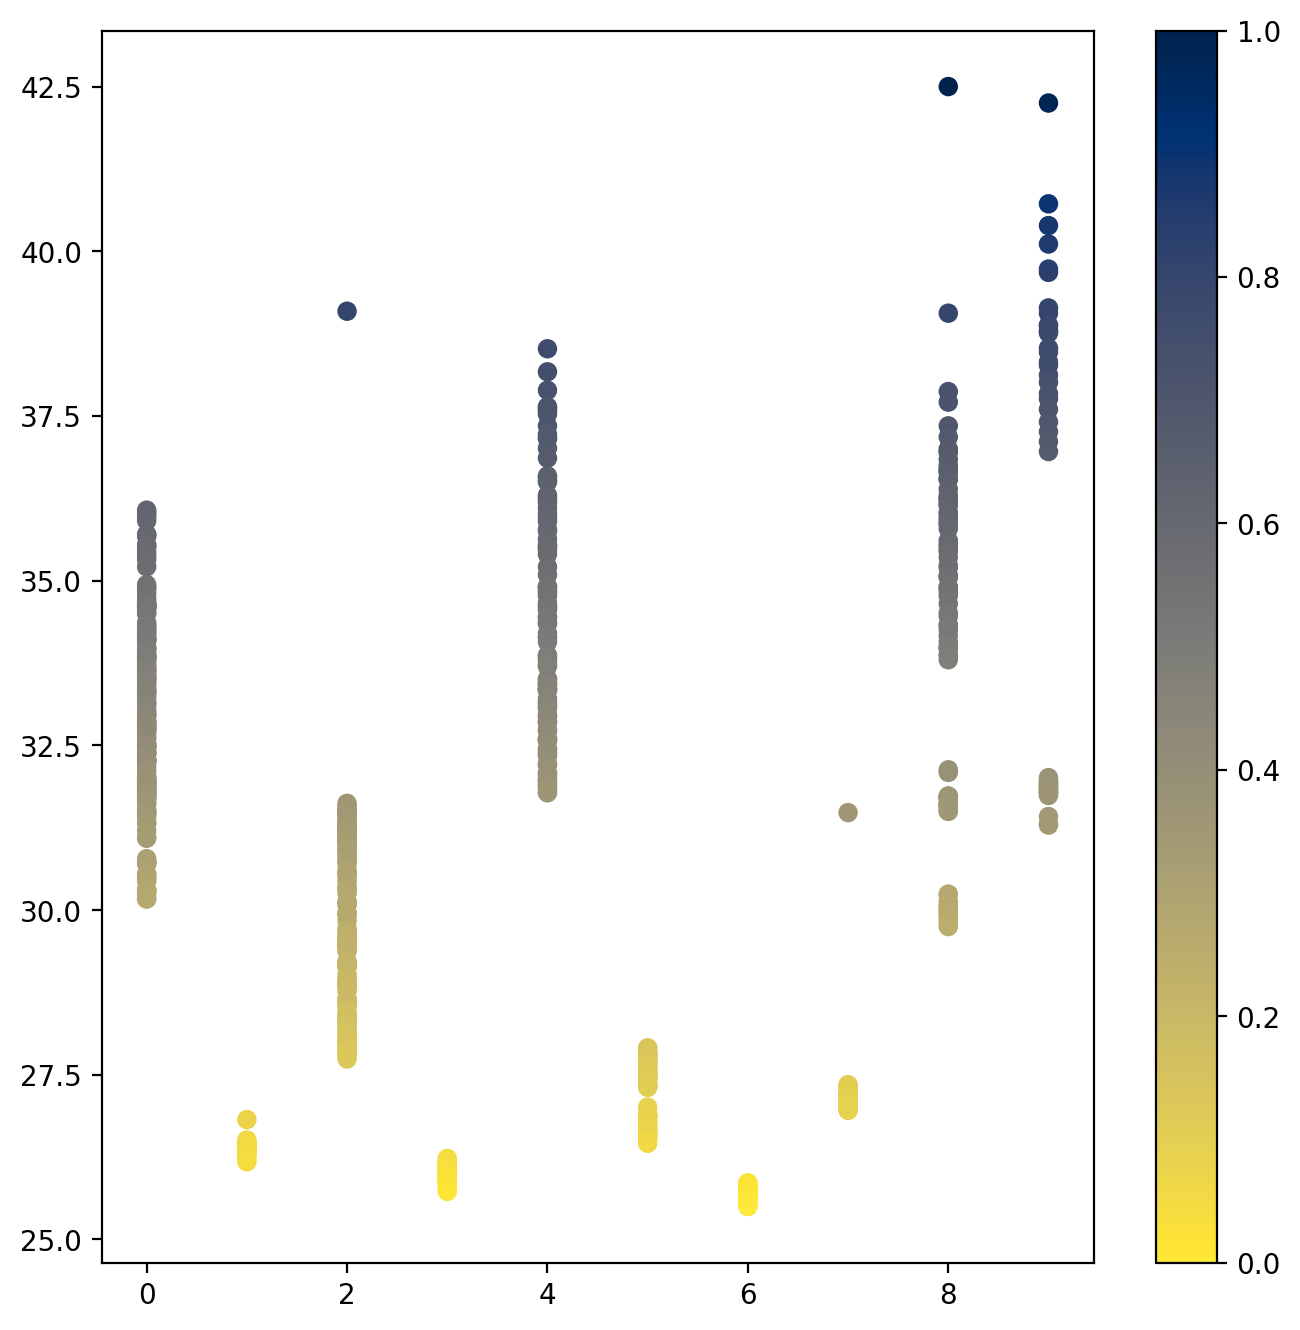

In [12]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10)
X_km = kmeans.fit_predict(X)

plt.figure(figsize=(8,8))
plt.scatter(X_km, y, c=norm(y), cmap=cmap)
plt.colorbar()
plt.show()

### 2.2.2 DBSCAN
See [sklearn.cluster.DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)

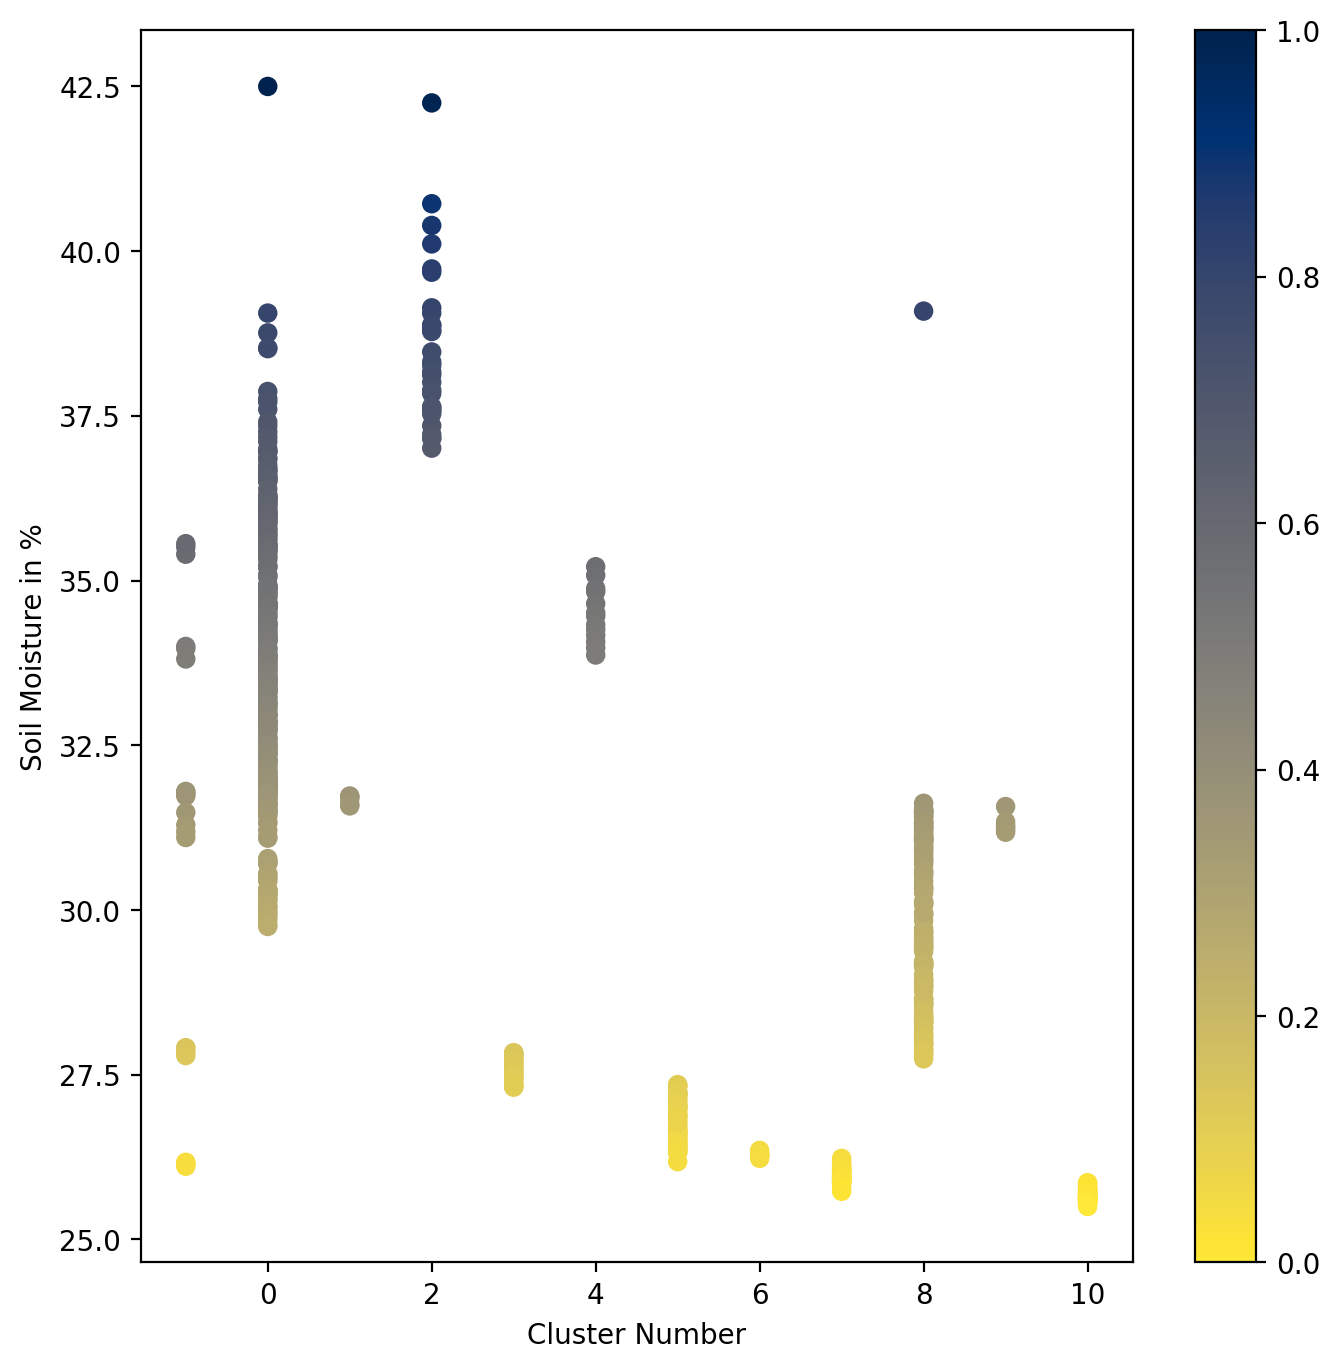

In [13]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.03)
X_db = dbscan.fit_predict(X)

plt.figure(figsize=(8,8))
# plt.hist(X_db[:])
plt.scatter(X_db, y, c=norm(y), cmap=cmap)
plt.xlabel("Cluster Number")
plt.ylabel("Soil Moisture in %")
plt.colorbar()
plt.show()

### 2.2.3 Self-organizing maps, SOM

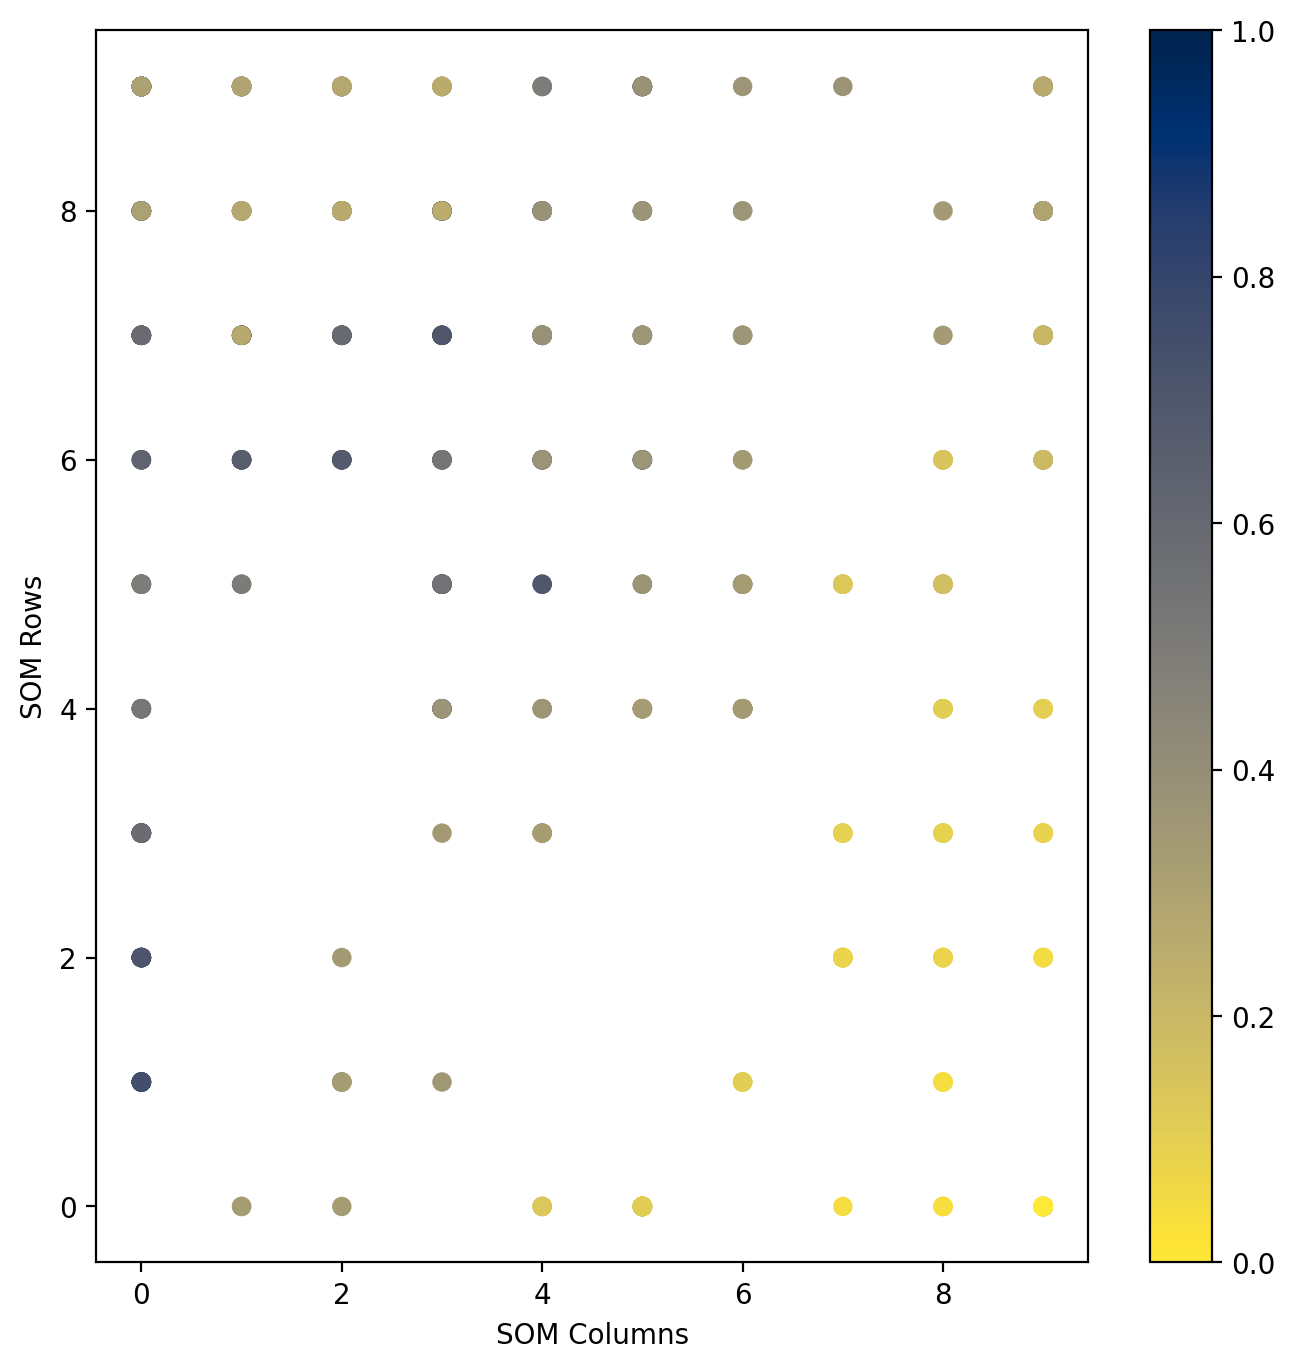

In [14]:
import susi

som = susi.SOMClustering()
X_som = som.fit_transform(X)

plt.figure(figsize=(8,8))
plt.scatter(X_som[:,0], X_som[:,1], c=norm(y), cmap=cmap)
plt.xlabel("SOM Columns")
plt.ylabel("SOM Rows")
plt.colorbar()
plt.show()

***

## 2.3 Feature Engineering and Feature Selection


- [2.3.1 Feature Engineering: Spectral example with NDVI](#2.3.1-Feature-Engineering:-Spectral-example-with-NDVI)
- [2.3.2 Feature Selection: Embedded Example with Random Forest](#2.3.2-Feature-Selection:-Embedded-Example-with-Random-Forest)

### 2.3.1 Feature Engineering: Spectral example with NDVI

In [15]:
# construct NDVI
def ndvi(x):
    """Define NDVI with 642nm and 814nm band."""
    return (x[47] - x[90]) / (x[47] + x[90])

X_ndvi = [ndvi(x) for x in X]

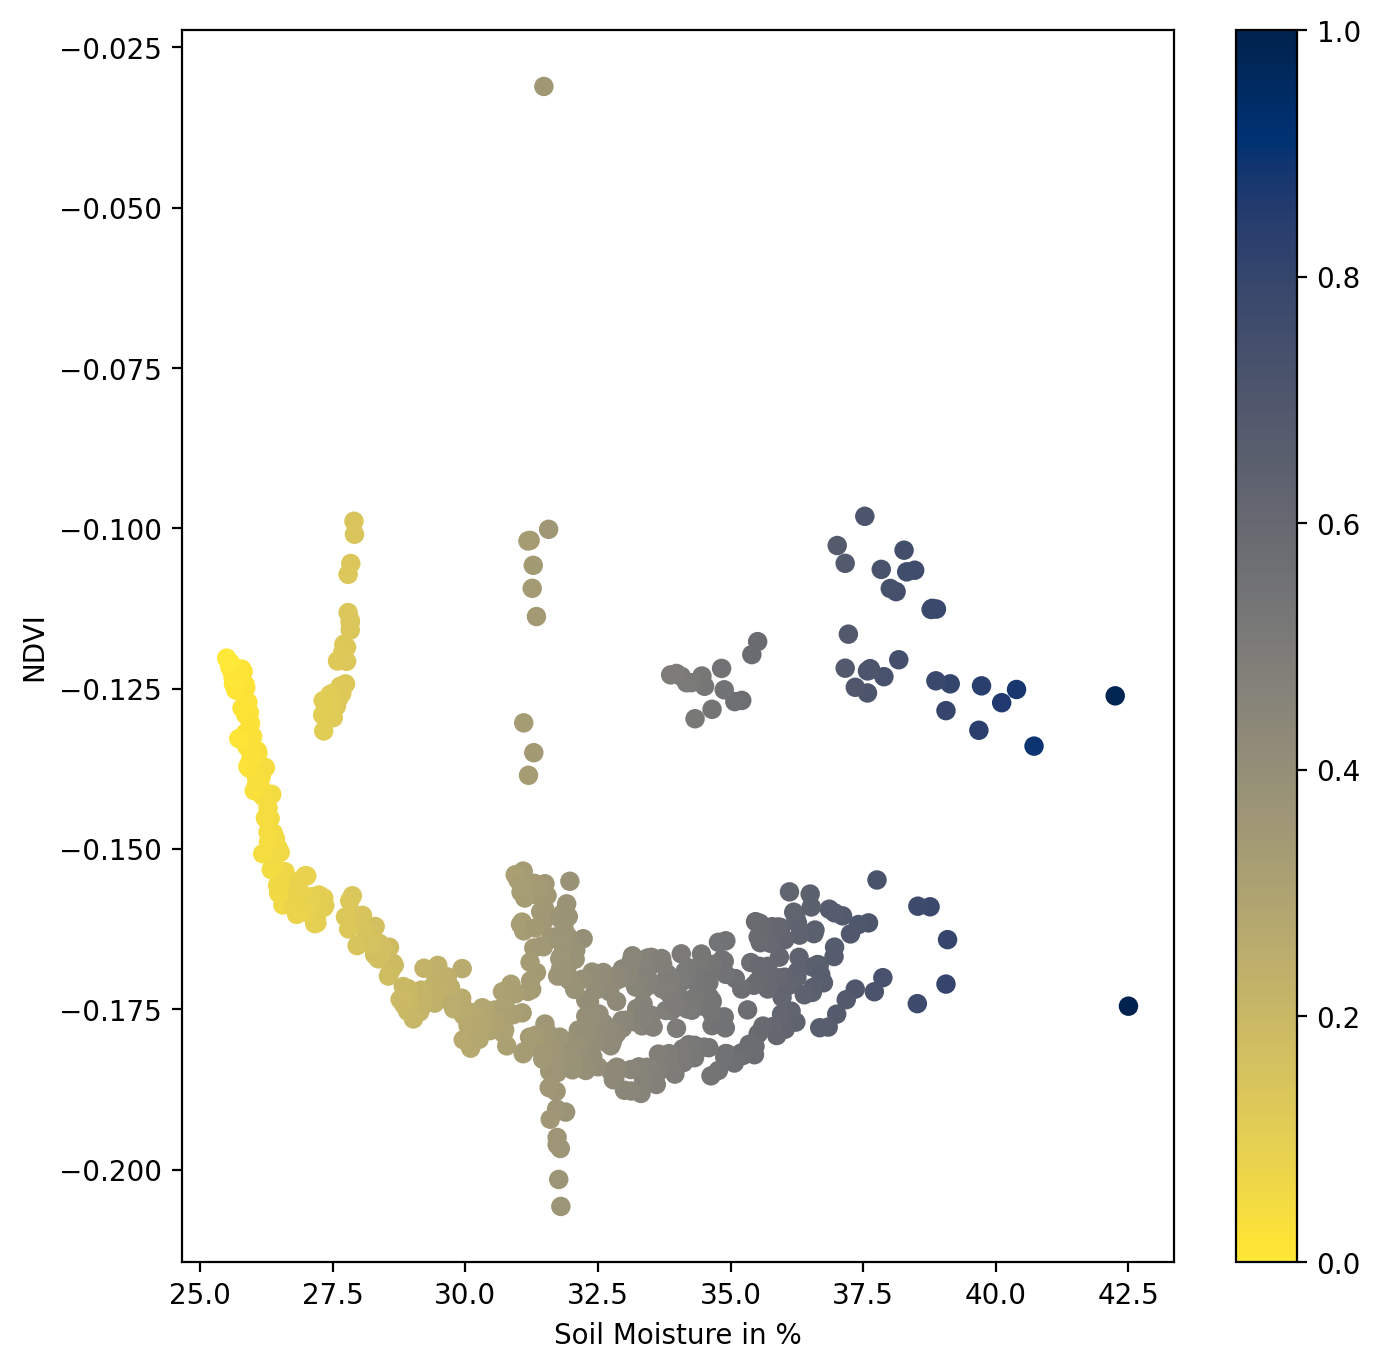

In [16]:
# correlation of NDVI with target variable (soil moisture)
plt.figure(figsize=(8,8))
plt.scatter(y, X_ndvi, c=norm(y), cmap=cmap)
plt.xlabel("Soil Moisture in %")
plt.ylabel("NDVI")
plt.colorbar()
plt.show()

### 2.3.2 Feature Selection: Embedded Example with Random Forest

In [17]:
from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=42)
model_rf.fit(X, y)

print("The 10 best features are:", *np.argsort(model_rf.feature_importances_[-10:]))

The 10 best features are: 1 4 3 0 6 5 7 2 9 8
